In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 모듈 설치

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from matplotlib import pyplot as plt
%matplotlib inline

## Cuda가 가능하면 cuda 아니면 cpu 설정

In [7]:
is_cuda = torch.cuda.is_available()
device = torch.device('cuda' if is_cuda else 'cpu')

print('Current cuda device is', device)

Current cuda device is cuda


## 파라미터 설정

In [8]:
batch_size = 50
learning_rate = 0.0001
epoch_num = 15

## MNIST 데이터 불러오기

In [9]:
train_data = datasets.MNIST(root = './data',
                            train = True,
                            download = True,
                            transform = transforms.ToTensor())
test_data = datasets.MNIST(root = './data',
                           train = False,
                           transform = transforms.ToTensor())

print('number of training data: ', len(train_data))
print('number of test data: ', len(test_data))

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

number of training data:  60000
number of test data:  10000


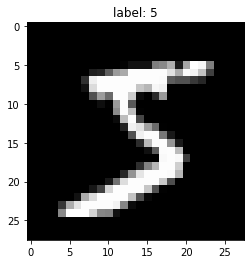

In [10]:
image, label = train_data[0]

plt.imshow(image.squeeze().numpy(), cmap='gray') # torch에서는 채널의 차원이 앞에 온다. squeeze() -> ex(28, 28)
plt.title('label: %s' % label) 
plt.show()

## 미니 배치 구성

In [11]:
train_loader = torch.utils.data.DataLoader(dataset=train_data,
                                           batch_size=batch_size, shuffle=True) # shuffle 데이터의 순서를 학습하지 않게
test_loader = torch.utils.data.DataLoader(dataset=test_data,
                                          batch_size=batch_size, shuffle=True)

first_batch = train_loader.__iter__().__next__()

In [13]:
print('{:15s} | {:<25s} | {}'.format('name', 'type', 'size'))
print('{:15s} | {:<25s} | {}'.format('Num of Batch', '', len(train_loader)))
print('{:15s} | {:<25s} | {}'.format('first_batch', str(type(first_batch)),
                                     len(first_batch)))
print('{:15s} | {:<25s} | {}'.format('first_batch[0]', str(type(first_batch[0])),
                                     first_batch[0].shape))
print('{:15s} | {:<25s} | {}'.format('first_batch[1]', str(type(first_batch[1])),
                                     first_batch[1].shape))

name            | type                      | size
Num of Batch    |                           | 1200
first_batch     | <class 'list'>            | 2
first_batch[0]  | <class 'torch.Tensor'>    | torch.Size([50, 1, 28, 28])
first_batch[1]  | <class 'torch.Tensor'>    | torch.Size([50])


## 모델 생성 - class로

In [14]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__() # 모듈 상속
        self.conv1 = nn.Conv2d(1, 32, 3, 1, padding='same') # 1개 채널 입력 -> 32개 채널 출력, kernel size = 3x3, stride = 1, padding = same
        self.conv2 = nn.Conv2d(32, 64, 3, 1, padding='same')
        self.dropout = nn.Dropout2d(0.25)
        self.fc1 = nn.Linear(3136, 1000) # 7*7*64 = 3136 -> 28x28 -> 14x14 -> 7x7 출력 채널 64 => 7*7*64
        self.fc2 = nn.Linear(1000, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2) # 풀링레이어는 가중치가 없다
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout(x)
        x = torch.flatten(x, 1) # keras에서는 차원을 1차원으로 펼치는 것과 가중치를 가지게끔 설정, pytorch에서는 단지 차원을 바꾼다
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1) # log_softmax는 연산 속도를 조금 더 높여줌
        return output

## 모델 학습

In [15]:
model = CNN().to(device) # device -> gpu
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

In [16]:
model.train() # 학습을 위한 선언
i = 1
for epoch in range(epoch_num):
    for data, target in train_loader:
        data = data.to(device) # gpu에 업로드
        target = target.to(device)
        optimizer.zero_grad() # 가중치 초기화
        output = model(data) 
        loss = criterion(output, target)
        loss.backward() # 역전파
        optimizer.step() # 가중치 업데이트
        if i % 1000 == 0:
            print('Train Step: {}\tLoss: {:.3f}'.format(i, loss.item()))
        i += 1

Train Step: 1000	Loss: 0.149
Train Step: 2000	Loss: 0.058
Train Step: 3000	Loss: 0.055
Train Step: 4000	Loss: 0.071
Train Step: 5000	Loss: 0.021
Train Step: 6000	Loss: 0.018
Train Step: 7000	Loss: 0.008
Train Step: 8000	Loss: 0.021
Train Step: 9000	Loss: 0.037
Train Step: 10000	Loss: 0.024
Train Step: 11000	Loss: 0.010
Train Step: 12000	Loss: 0.010
Train Step: 13000	Loss: 0.017
Train Step: 14000	Loss: 0.004
Train Step: 15000	Loss: 0.004
Train Step: 16000	Loss: 0.031
Train Step: 17000	Loss: 0.024
Train Step: 18000	Loss: 0.012


## 모델 평가

In [17]:
model.eval() # 모델 평가 모드 -> dropout은 자동으로 꺼짐
correct = 0
for data, target in test_loader:
    data = data.to(device)
    target = target.to(device)
    output = model(data)
    prediction = output.data.max(1)[1]
    correct += prediction.eq(target.data).sum()

print('Test set Accuracy: {:.2f}%'.format(100. * correct / len(test_loader.dataset)))

Test set Accuracy: 99.05%
